In [23]:
import os, sys
import numpy as np
import pandas as pd
import sklearn as skl
from sklearn.neighbors import NearestNeighbors, DistanceMetric
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

from yutil import PDF


http://stats.stackexchange.com/questions/30588/deriving-the-conditional-distributions-of-a-multivariate-normal-distribution
$\newcommand{\v}[1]{{\bf #1}}$
$\newcommand{\z}{{\bf z}}$
$\newcommand{\C}{{\bf C}}$
$\newcommand{\C1}{{\bf C_1}}$
$\newcommand{\C2}{{\bf C_2}}$
$\newcommand{\x1}{{\bf x_1}}$
$\newcommand{\x}{{\bf x}}$
$\newcommand{\x2}{{\bf x_2}}$
$\newcommand{\P}{\mathcal{P}}

We start with saying we want a linear combination $\z=\C\x=\C_1\x_1+\C_2\x_2 $ of the whole vector that is independent/uncorrelated with $\x_2$. This is because we can use the fact that $p(\z|\x_2)=p(\z)$ which means $var(\z|\x_2)=var(\z)$ and $E(\z|\x_2)=E(\z)$. These in turn lead to expressions for $var(\C_1\x_1|\x_2)$ and $E(\C_1\x_1|\x_2)$. This means we should take $\C_1=I$. Now we require $cov(\z,\x_2)=Σ_{12}+\C_2Σ_{22}=0$. If $Σ_{22}$ is invertible we then have $C2=−Σ_{12}Σ_{22}−1$.
 
Let x1x1 be the first partition and x2x2 the second. Now define z=x1+Ax2z=x1+Ax2 where A=−Σ12Σ−122A=−Σ12Σ22−1. Now we can write

cov(z,x2)=cov(x1,x2)+cov(Ax2,x2)=Σ12+Avar(x2)=Σ12−Σ12Σ−122Σ22=0
cov(z,x2)=cov(x1,x2)+cov(Ax2,x2)=Σ12+Avar(x2)=Σ12−Σ12Σ22−1Σ22=0
Therefore zz and x2x2 are uncorrelated and, since they are jointly normal, they are independent. Now, clearly E(z)=μ1+Aμ2E(z)=μ1+Aμ2, therefore it follows that

E(x1|x2)=E(z−Ax2|x2)=E(z|x2)−E(Ax2|x2)=E(z)−Ax2=μ1+A(μ2−x2)=μ1+Σ12Σ−122(x2−μ2)
E(x1|x2)=E(z−Ax2|x2)=E(z|x2)−E(Ax2|x2)=E(z)−Ax2=μ1+A(μ2−x2)=μ1+Σ12Σ22−1(x2−μ2)
which proves the first part. For the covariance matrix, note that

var(x1|x2)=var(z−Ax2|x2)=var(z|x2)+var(Ax2|x2)−Acov(z,−x2)−cov(z,−x2)A′=var(z|x2)=var(z)
var(x1|x2)=var(z−Ax2|x2)=var(z|x2)+var(Ax2|x2)−Acov(z,−x2)−cov(z,−x2)A′=var(z|x2)=var(z)
Now we're almost done:

var(x1|x2)=var(z)=var(x1+Ax2)=var(x1)+Avar(x2)A′+Acov(x1,x2)+cov(x2,x1)A′=Σ11+Σ12Σ−122Σ22Σ−122Σ21−2Σ12Σ−122Σ21=Σ11+Σ12Σ−122Σ21−2Σ12Σ−122Σ21=Σ11−Σ12Σ−122Σ21
var(x1|x2)=var(z)=var(x1+Ax2)=var(x1)+Avar(x2)A′+Acov(x1,x2)+cov(x2,x1)A′=Σ11+Σ12Σ22−1Σ22Σ22−1Σ21−2Σ12Σ22−1Σ21=Σ11+Σ12Σ22−1Σ21−2Σ12Σ22−1Σ21=Σ11−Σ12Σ22−1Σ21
which proves the second part.

Note: For those not very familiar with the matrix algebra used here, this is an excellent resource.

Edit: One property used here this is not in the matrix cookbook (good catch @FlyingPig) is property 6 on the wikipedia page about covariance matrices: which is that for two random vectors x,yx,y,
var(x+y)=var(x)+var(y)+cov(x,y)+cov(y,x)
var(x+y)=var(x)+var(y)+cov(x,y)+cov(y,x)
For scalars, of course, cov(X,Y)=cov(Y,X)cov(X,Y)=cov(Y,X) but for vectors they are different insofar as the matrices are arranged differently.

share 

In [70]:
PDF.open('derivations_alan_eq7.pdf',size=(1000,350))

In [125]:
#
def theory_evidence():
    pass

def data_evidence(S,D,L):
    a=2.0/(S+1)*np.sum(D*L)
    px=a*S
    return a,px

def gauss_nrom1d(x,mean,var):
    return 1.0/np.sqrt(2*np.pi*var)*np.exp(-0.5*(x-mean)**2/var)

def gibbs_samples_wcorr(n=1000,mean=(1,10),std=(0.2,0.5),corr=0.099):
    #Means: 
    m1=mean[0]; m2=mean[1]
    #Standard deviations: s1,s2
    s1=std[0]; s2=std[1]
    
    #Initialize vectors
    x=np.zeros(n)
    y=np.zeros(n)
    #correlation
    rho=corr 
    sd=np.sqrt(1-rho**2)
    # The mean for the current sample, is updated at each step.
    for i in range(1,n):
      x[i] = np.random.normal(m1+rho*(y[i-1]-m2)/s2,s1*sd)
      y[i] = np.random.normal(m2+rho*(x[i-1]-m1)/s1,s2*sd)        
        
    return x[1:], y[1:]
#
def gibbs_samples(n=1000,mean=(1,10),std=(0.2,0.5)):
    #Means: 
    m1=mean[0]; m2=mean[1]
    #Standard deviations: s1,s2
    s1=std[0]; s2=std[1]
    
    #Initialize vectors
    x=np.zeros(n)
    y=np.zeros(n)
    # The mean for the current sample, is updated at each step.
    for i in range(1,n):
      x[i] = np.random.normal(m1,s1)
      y[i] = np.random.normal(m2,s2)
        
    return x[1:], y[1:]

In [ ]:
#  Generate data
ndata=10000
ndim=2
d2d=np.random.normal((1,1),(0.2,0.5),size=(ndata,ndim))
print(d2d.shape)
plt.scatter(d2d[:,0],d2d[:,1],s=0.1)
plt.title('Data ndata='+str(ndata))
# the sample mean and variance
mean_sample=np.mean(d2d,axis=0)
var_sample=np.var(d2d,axis=0)/np.float(ndata)
std_sample=np.sqrt(var_sample)

#compute the constant term for the likelihood
tx=np.sum(d2d[:,0]**2)/var_sample[0]
ty=np.sum(d2d[:,1]**2)/var_sample[1]

print('mean_sample, std_sample',mean_sample, std_sample)

#Given data, get samples for the mean mu_x and mu_y
nchain=10000
xs,ys=gibbs_samples(n=nchain,mean=mean_sample,std=std_sample)
#compute likelihood

In [123]:
Like=(gauss_nrom1d(xs,mean_sample[0],var_sample[0])*
              gauss_nrom1d(ys,mean_sample[1],var_sample[1]))
nlogL=-np.log(Like) #+ tx + ty

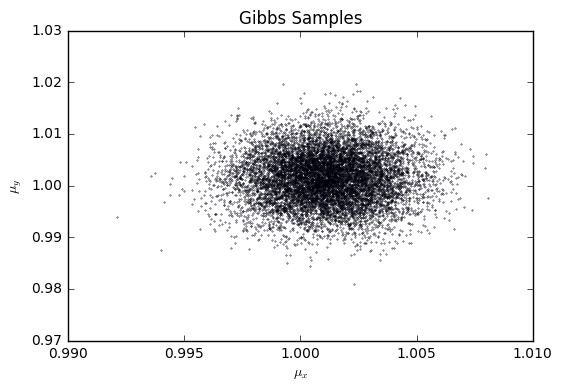

In [98]:
plt.scatter(xs,ys,s=0.1)
plt.title('Gibbs Samples')
plt.xlabel('$\mu_x$')
plt.ylabel('$\mu_y$')

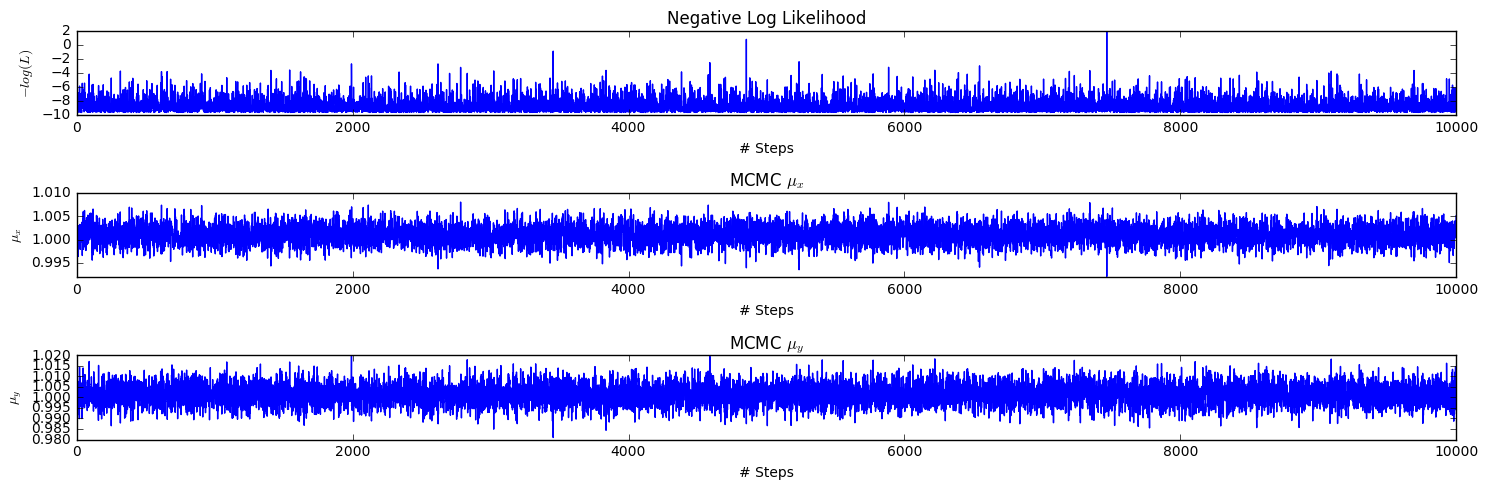

In [105]:
fig,ax=plt.subplots(figsize=(15,5))
plt.subplot(3,1,1)
plt.plot(nlogL)
plt.xlabel('# Steps')
plt.ylabel('$-log(L)$')
plt.title('Negative Log Likelihood')

plt.subplot(3,1,2)
plt.plot(xs)
plt.xlabel('# Steps')
plt.ylabel('$\mu_x$')
plt.title('MCMC $\mu_x$')

plt.subplot(3,1,3)
plt.plot(ys)
plt.xlabel('# Steps')
plt.ylabel('$\mu_y$')
plt.title('MCMC $\mu_y$')

plt.tight_layout()

In [112]:
dist = DistanceMetric.get_metric('euclidean')
chain=np.vstack((xs, ys)).T
print(chain.shape)
nnd=dist.pairwise(chain)


(9999, 2)


In [116]:
nnd[np.where(nnd==0)]=1e30
nnd_1k=nnd.min(axis=1)
nnd_1k.shape

(9999,)

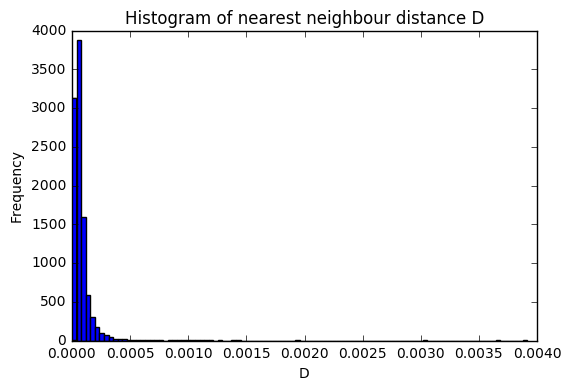

In [122]:
plt.hist(nnd_1k,bins=100)
plt.xlabel('D')
plt.ylabel('Frequency')
plt.title('Histogram of nearest neighbour distance D')

In [128]:
a,dpx=data_evidence(nchain,nnd_1k,Like)

#nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(chain)
#distances, indices = nbrs.kneighbors(X)

#kdt = KDTree(d2d, leaf_size=30, metric='euclidean')
#kdt.query(d2d, k=2, return_distance=False) 

In [132]:
#plt.plot(a)
dpx

8494.2295037265994

In [ ]:
from scipy import *
from scipy.linalg import *
from numpy.random import *
from scipy.stats.distributions import *

def qCondMVnor(P, rsNormVec, cpar, meanVec, covMatx):
    x2 = delete(rsNormVec, cpar)
    mu2 = delete(meanVec, cpar)
    mu1 = meanVec[cpar]
    cov22 = delete(delete(covMatx, s_[cpar], axis=0), s_[cpar], axis=1)
    cov12 = delete(covMatx[1,:], cpar, axis=1)
    cov21 = delete(covMatx[:,1], cpar, axis=0)
    sd = float(sqrt(covMatx[cpar, cpar] - cov12*inv(cov22)*cov21))
    mean = float(mu1 + cov12*inv(cov22)*(matrix(x2 - mu2).reshape(2,1)))
    return norm.ppf(P, loc=mean, scale=sd)